# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import datetime
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# installing a sentiment analysier
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
root_dir = '/content/drive/MyDrive/NLP Final Project'

# Load LSTM Sentiment Analysis Model

In [5]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from tensorflow import keras
import pickle
from keras.preprocessing.sequence import pad_sequences
lstm_sentiment_model = keras.models.load_model(f'{root_dir}/Models/LSTM_SA/model')
with open(f'{root_dir}/Models/LSTM_SA/tokenizer.pickle', 'rb') as handle:
    lstm_tokenizer = pickle.load(handle)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Bert Sentiment Analysis Model

In [6]:
import transformers
class BERTBaseUncased(nn.Module):
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased', 
                                                           return_dict=False)
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, 1)
    
    def forward(self, ids, mask, token_type_ids):
        _, o2 = self.bert(ids, attention_mask=mask,token_type_ids=token_type_ids)
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output

In [7]:
bert_sentiment_model = torch.load(f'{root_dir}/Models/Bert_SA/bert_model.pth')

In [8]:
with open(f'{root_dir}/Models/Bert_SA/bert_tokenizer.pickle', 'rb') as handle:
    bert_tokenizer = pickle.load(handle)
bert_max_len = 50

# Load Datasets

In [9]:
company_tweet = pd.read_csv(f'{root_dir}/Company_Tweet.csv')
tweet = pd.read_csv(f'{root_dir}/Tweet.csv')
company = pd.read_csv(f'{root_dir}/Company.csv')
news = pd.read_csv(f'{root_dir}/us_equities_news_dataset.csv')
aapl_stocks = pd.read_csv(f'{root_dir}/AAPL.csv')
msft_stocks = pd.read_csv(f'{root_dir}/MSFT.csv')
amzn_stocks = pd.read_csv(f'{root_dir}/AMZN.csv')
tsla_stocks = pd.read_csv(f'{root_dir}/TSLA.csv')

In [10]:
tweets = pd.merge(company_tweet , tweet , on="tweet_id", how="inner")

# Preparing the Data

In [11]:
# preprocess the data

def clean_text(text, stem=False):
    stop_words = stopwords.words('english')
    stemmer = SnowballStemmer('english')

    text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

def preprocess_tweets(tweets):
    total = tweets['comment_num'] + tweets['retweet_num'] + tweets['like_num']
    tweets['total_engangement'] = total
    tweets['date'] = pd.to_datetime(tweets['post_date'],unit='s').dt.strftime('%Y-%m-%d')
    filtered = tweets.loc[tweets['total_engangement'] > 200]
    filtered = filtered.drop(labels='post_date' ,axis=1)
    filtered = filtered.sort_values(['total_engangement'] , ascending = False)
    filtered['body'] = filtered['body'].apply(lambda x: clean_text(x))
    filtered = filtered.sort_values(['date'] , ascending = True)
    return filtered

def preprocess_news(news):
    filtered = news.loc[news['category'] == 'news']
    filtered = filtered.loc[news['release_date'] >= '2015-01-01']
    filtered = filtered.loc[filtered['release_date'] <= '2019-12-31']
    filtered = filtered.sort_values(['release_date'] , ascending = False)
    filtered = filtered.drop(labels=['id', 'title', 'provider', 'url', 'article_id'] ,axis=1)
    filtered = filtered.loc[filtered['ticker'].isin(['AAPL', 'TSLA', 'MSFT', 'AMZN'])]
    filtered['content'] = filtered['content'].apply(lambda x: clean_text(x))
    return filtered

def preprocess_stocks(stocks):
    filtered = stocks.drop(labels=['Open', 'High', 'Low', 'Close'] ,axis=1)
    filtered['Change'] = filtered['Adj Close'].pct_change()
    filtered.at[0, 'Change'] = 0
    return filtered

In [12]:
# we want a different dataset for each sentiment analysis model
# essentialy that means we want a different 'sentiment' column for tweets and news
clean_tweets = preprocess_tweets(tweets)
clean_news = preprocess_news(news)

In [13]:
# sentiment functions

def get_nothing_sentiment(texts):
    return [0] * (len(texts))

def get_vader_sentiment(texts):
    def get_sentiment(text):
        analyzer = SentimentIntensityAnalyzer()
        assert text is not None
        vs = analyzer.polarity_scores(text)
        score = vs['compound']

        # if (score >= 0.05): 
        #     return "Positive"
        # elif (score < 0.05 and score > -0.05):
        #     return "Neutral"
        # elif (score <= -0.05):    
        #     return "Negetive"
        return score
    return texts.apply(lambda x: get_sentiment(x))

def get_lstm_sentiment(texts):
    # the score is between 0 to 1.
    # above 0.5 is positive, under is negative
    tokenized_texts = pad_sequences(lstm_tokenizer.texts_to_sequences(texts.tolist()),
                       maxlen = 30)
    scores = lstm_sentiment_model.predict(tokenized_texts)
    #return scores
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_scores = scaler.fit_transform(scores)
    return scaled_scores.ravel().tolist()

def get_cnn_sentiment(texts):
    pass

def get_bert_sentiment(texts):
    scores = texts.apply(lambda x: bert_sentence_sentiment_prediction(x))
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_scores = scaler.fit_transform(np.array(scores.tolist()).reshape(-1, 1))
    return scaled_scores.ravel().tolist()

def bert_sentence_sentiment_prediction(sentence):
    review = str(sentence)
    review = " ".join(review.split())

    inputs = bert_tokenizer.encode_plus(review, None, add_special_tokens=True, 
                                   max_length=bert_max_len)
    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    padding_length = bert_max_len - len(ids)
    ids = ids + ([0] * padding_length)
    mask = mask + ([0] * padding_length)
    token_type_ids = token_type_ids + ([0] * padding_length)

    ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0)
    mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0)
    token_type_ids = torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0)

    ids = ids.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype=torch.long)
    mask = mask.to(device, dtype=torch.long)

    outputs = bert_sentiment_model(ids=ids, mask=mask, token_type_ids=token_type_ids)
    outputs = torch.sigmoid(outputs).cpu().detach().numpy()
    return outputs[0][0]

In [14]:
def create_dataset(all_tweets, all_news, stocks, ticker, sentiment_func):
    tweets = all_tweets.loc[all_tweets['ticker_symbol'] == ticker]
    tweets['sentiment'] = sentiment_func(tweets['body'])
    news = all_news.loc[all_news['ticker'] == ticker]
    news['sentiment'] = sentiment_func(news['content'])
    dates = stocks['Date'].tolist()

    data = []
    for date in dates:
        stock_for_date = stocks.loc[stocks['Date'] == date]
        price = stock_for_date.iloc[0]['Adj Close']
        volume = stock_for_date.iloc[0]['Volume']
        change = stock_for_date.iloc[0]['Change']

        tweets_for_date = tweets.loc[tweets['date'] == date]
        if not tweets_for_date.empty:
            mean_sentiment_tweets = tweets_for_date['sentiment'].mean()
        else:
            mean_sentiment_tweets = 0

        news_for_date = news.loc[news['release_date'] == date]
        if not news_for_date.empty:
            mean_sentiment_news = news_for_date['sentiment'].mean()
        else:
            mean_sentiment_news = 0

        # TODO: add feature for stock price 3-7 days prior
        
        data.append([mean_sentiment_tweets, mean_sentiment_news, change, volume, price])
    return np.array(data, dtype=np.float32)

In [15]:
# 0 = nothing, 1 = vader, 2 = lstm, 3 = bert, 4 = cnn
clean_aapl_stocks = preprocess_stocks(aapl_stocks)
aapl_datasets = [
    create_dataset(clean_tweets, clean_news, clean_aapl_stocks, 'AAPL', get_nothing_sentiment),
    create_dataset(clean_tweets, clean_news, clean_aapl_stocks, 'AAPL', get_vader_sentiment),
    create_dataset(clean_tweets, clean_news, clean_aapl_stocks, 'AAPL', get_lstm_sentiment),
    create_dataset(clean_tweets, clean_news, clean_aapl_stocks, 'AAPL', get_bert_sentiment)
]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [16]:
# clean_msft_stocks = preprocess_stocks(msft_stocks)
# msft_datasets = [
#     create_dataset(clean_tweets, clean_news, clean_msft_stocks, 'MSFT', get_nothing_sentiment),
#     create_dataset(clean_tweets, clean_news, clean_msft_stocks, 'MSFT', get_vader_sentiment),
#     create_dataset(clean_tweets, clean_news, clean_msft_stocks, 'MSFT', get_lstm_sentiment),
#     create_dataset(clean_tweets, clean_news, clean_msft_stocks, 'MSFT', get_bert_sentiment)
# ]

In [17]:
# clean_amzn_stocks = preprocess_stocks(amzn_stocks)
# amzn_datasets = [
#     create_dataset(clean_tweets, clean_news, clean_amzn_stocks, 'AMZN', get_nothing_sentiment),
#     create_dataset(clean_tweets, clean_news, clean_amzn_stocks, 'AMZN', get_vader_sentiment),
#     create_dataset(clean_tweets, clean_news, clean_amzn_stocks, 'AMZN', get_lstm_sentiment),
#     create_dataset(clean_tweets, clean_news, clean_amzn_stocks, 'AMZN', get_bert_sentiment)
# ]

In [ ]:
# clean_tsla_stocks = preprocess_stocks(tsla_stocks)
# tsla_datasets = [
#     create_dataset(clean_tweets, clean_news, clean_tsla_stocks, 'TSLA', get_nothing_sentiment),
#     create_dataset(clean_tweets, clean_news, clean_tsla_stocks, 'TSLA', get_vader_sentiment),
#     create_dataset(clean_tweets, clean_news, clean_tsla_stocks, 'TSLA', get_lstm_sentiment),
#     create_dataset(clean_tweets, clean_news, clean_tsla_stocks, 'TSLA', get_bert_sentiment)
# ]

In [19]:
def scale_dataset(data, volume_scaler, price_scaler):
    volume_column = data[:, 3].astype(float)
    price_column = data[:, 4].astype(float)
    filtered_data = np.delete(data, [3, 4], 1)

    scaled_volume = volume_scaler.fit_transform(volume_column.reshape(-1, 1))
    scaled_price = price_scaler.fit_transform(price_column.reshape(-1, 1))
    volumne_and_price = np.append(scaled_volume, scaled_price, axis=1)
    scaled_data = np.append(filtered_data, volumne_and_price, axis=1)
    return scaled_data

In [20]:
aapl_volume_scaler = MinMaxScaler(feature_range=(-1, 1))
aapl_price_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_aapl_datasets = [scale_dataset(data, aapl_volume_scaler, aapl_price_scaler).astype(float) for data in aapl_datasets]

# msft_volume_scaler = MinMaxScaler(feature_range=(-1, 1))
# msft_price_scaler = MinMaxScaler(feature_range=(-1, 1))
# scaled_msft_datasets = [scale_dataset(data, msft_volume_scaler, msft_price_scaler).astype(float) for data in msft_datasets]

# amzn_volume_scaler = MinMaxScaler(feature_range=(-1, 1))
# amzn_price_scaler = MinMaxScaler(feature_range=(-1, 1))
# scaled_amzn_datasets = [scale_dataset(data, amzn_volume_scaler, amzn_price_scaler).astype(float) for data in amzn_datasets]

# tsla_volume_scaler = MinMaxScaler(feature_range=(-1, 1))
# tsla_price_scaler = MinMaxScaler(feature_range=(-1, 1))
# scaled_tsla_datasets = [scale_dataset(data, tsla_volume_scaler, tsla_price_scaler).astype(float) for data in tsla_datasets]

In [21]:
# prepare sequences and split to train and test

def create_sequences(input, tw):
    seqs = []
    labels = []
    L = len(input)
    print(f'length: {L}')
    for i in range(L-tw):
        data_seq = input[i:i+tw]
        #print(f'data_seq: {data_seq}')
        data_label = input[i+tw:i+tw+1][0][4]
        #print(f'label: {data_label}')
        seqs.append(data_seq)
        labels.append(data_label)
    
    print('size of data : ', len(seqs))
    return seqs, labels

def split_train_and_test(input, test_share):
    test_set_size = int(len(input) * test_share)
    train_set_size = len(input) - test_set_size
    print('size of train : ', train_set_size)
    print('size of test : \n', test_set_size)
     
    # train days come before test days
    train = input[:train_set_size]
    test = input[train_set_size:]

    # test days come before train days
    # train = input[(len(input) - train_set_size):]
    # test = input[:train_set_size]
  
    return train, test

def prepare_test_and_train(data, train_window, test_share):
    X, y = create_sequences(data, train_window)
    X_train, X_test = split_train_and_test(X, test_share)
    y_train, y_test = split_train_and_test(y, test_share)
    return [(X_train, y_train), (X_test, y_test)]

In [73]:
train_window = 4
test_share = 0.2

splitted_aapl_datasets = [prepare_test_and_train(data, train_window, test_share) for data in scaled_aapl_datasets]
# splitted_msft_datasets = [prepare_test_and_train(data, train_window, test_share) for data in scaled_msft_datasets]
# splitted_amzn_datasets = [prepare_test_and_train(data, train_window, test_share) for data in scaled_amzn_datasets]
# splitted_tsla_datasets = [prepare_test_and_train(data, train_window, test_share) for data in scaled_tsla_datasets]

length: 1257
size of data :  1253
size of train :  1003
size of test : 
 250
size of train :  1003
size of test : 
 250
length: 1257
size of data :  1253
size of train :  1003
size of test : 
 250
size of train :  1003
size of test : 
 250
length: 1257
size of data :  1253
size of train :  1003
size of test : 
 250
size of train :  1003
size of test : 
 250
length: 1257
size of data :  1253
size of train :  1003
size of test : 
 250
size of train :  1003
size of test : 
 250


## Model

In [45]:
class LSTM(nn.Module):
    def __init__(self, input_size=5, hidden_layer_size=150, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        #self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        output, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        #output = self.dropout(output)
        output = self.linear(output)
        return output

In [46]:
def train_model(model, criterion, optimizer, epochs, train_data, test_data, price_scaler):
    train_loss, test_loss, mses = [], [], []
    X_train, y_train = train_data
    X_test, y_test = test_data
    for i in range(1, epochs + 1):
        # Training phase
        #print(f'##### Training Phase Epoch {i} #####')
        model.train()
        for train_seq, train_label in zip(X_train, y_train):
            #print(seq)
            #print(label)
            train_seq = torch.from_numpy(train_seq).type(torch.Tensor)
            train_seq = train_seq.to(device)
            train_label = torch.from_numpy(np.array(train_label)).type(torch.Tensor)
            train_label = train_label.to(device)
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size, device=device),
                             torch.zeros(1, 1, model.hidden_layer_size, device=device))

            output = model(train_seq)
            train_prediction = output[-1]
            train_label = train_label.view(1)
            # print(f'train_label after view: {train_label}')
            loss = criterion(train_prediction, train_label)
            loss.backward()
            optimizer.step()
    
        train_loss.append(loss.item())
        print(f'epoch: {i:3} loss: {loss.item():10.10f}')
    
        # Evaluation Phase
        #print(f'##### Evaluation Phase Epoch {i} #####')
        model.eval()
        epoch_test_loss = []
        with torch.no_grad():
            for test_seq, test_label in zip(X_test, y_test):
                test_seq = torch.from_numpy(np.array(test_seq)).type(torch.Tensor)
                test_seq = test_seq.to(device)
                test_label = torch.from_numpy(np.array(test_label)).type(torch.Tensor)
                test_label = test_label.to(device)
                model.hidden = (torch.zeros(1, 1, model.hidden_layer_size, device=device),
                            torch.zeros(1, 1, model.hidden_layer_size, device=device))
        
                output = model(test_seq)
                test_prediction = output[-1]
                test_label = test_label.view(1)
                #print(f'test_prediction: {test_prediction}')
                #print(f'test_label: {test_label}')
                loss = criterion(test_prediction, test_label)
                epoch_test_loss.append(loss.item())
        test_loss.append(sum(epoch_test_loss) / len(epoch_test_loss))
        mse = (np.square(test_label.cpu().detach().numpy() - test_prediction.cpu().detach().numpy())).mean(axis=None)
        mses.append(mse)
    
    plot_losses2(train_loss, test_loss, price_scaler)
    print('Finished training model\n')
    return mses

In [47]:
def plot_losses2(train_loss, test_loss, price_scaler):
    f, _ = plt.subplots(nrows=1,ncols=3,figsize=(25,5))
    f.tight_layout(pad=5.0)

    plt.subplot(1, 3, 1)
    plt.title('Train Loss')
    plt.plot(train_loss, label='Train')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.title('Test Loss')
    plt.plot(test_loss, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.title('Loss history')
    plt.plot(train_loss, label='Train')
    plt.plot(test_loss, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [48]:
def evaluate_model(model, test_data, price_scaler):
    X_test, y_test = test_data
    model.eval()
    actual=[]
    pred = []
    with torch.no_grad():
        for seq, label in zip(X_test, y_test):
            #print(seq)
            #print(label)
            seq = torch.from_numpy(np.array(seq)).type(torch.Tensor)
            seq = seq.to(device)
            label = torch.from_numpy(np.array(label)).type(torch.Tensor)
            label = label.to(device)
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size, device=device),
                        torch.zeros(1, 1, model.hidden_layer_size, device=device))
        
            output = model(seq)[-1]
            pred.append(output.item())
            actual.append(label.item())

    predicted_prices = price_scaler.inverse_transform(np.array(pred).reshape(-1, 1))
    real_prices = price_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))

    print('Finished evaluating model\n')
    return real_prices, predicted_prices

In [49]:
# Plot MSES
def plot_mses(company, mses):
    f, _ = plt.subplots(nrows=1,ncols=1,figsize=(15,7))
    f.tight_layout(pad=5.0)

    plt.plot(mses[0], label='Neutral Sentiment')
    plt.plot(mses[1], label='Vader')
    plt.plot(mses[2], label='LSTM')
    plt.plot(mses[3], label='Bert')
    plt.title(f'{company}: MSE Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

In [50]:
# Plot Price Prediction
def plot_price_prediction(company, real, predicted):
    f, _ = plt.subplots(nrows=1,ncols=1,figsize=(15,7))
    f.tight_layout(pad=5.0)

    plt.plot(real[0], label='Real')
    plt.plot(predicted[0], label='No Sentiment')
    plt.plot(predicted[1], label='Vader')
    plt.plot(predicted[2], label='LSTM')
    plt.plot(predicted[3], label='Bert')
    plt.title(f'{company}: Predicted Prices')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [74]:
def process_company(company, datasets, price_scaler, epochs, lr):
    real, predicted, mses = [], [], []
    for train_data, test_data in datasets:
        model = LSTM()
        model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        mses.append(train_model(model, criterion, optimizer, epochs, train_data, test_data, price_scaler))
        real_prices, predicted_prices = evaluate_model(model, test_data, price_scaler)

        real.append(real_prices)
        predicted.append(predicted_prices)
    
    plot_mses(company, mses)
    plot_price_prediction(company, real, predicted)

In [75]:
epochs = 15
lr = 0.001

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.0173790250
epoch:   2 loss: 0.0457406156
epoch:   3 loss: 0.0338510387
epoch:   4 loss: 0.0251322612
epoch:   5 loss: 0.0165758021
epoch:   6 loss: 0.0119385207
epoch:   7 loss: 0.0076514953
epoch:   8 loss: 0.0051502758
epoch:   9 loss: 0.0033175806
epoch:  10 loss: 0.0018233530
epoch:  11 loss: 0.0017323572
epoch:  12 loss: 0.0012379911
epoch:  13 loss: 0.0008820942
epoch:  14 loss: 0.0009645280
epoch:  15 loss: 0.0008488076
epoch:  16 loss: 0.0010480640
epoch:  17 loss: 0.0006756758
epoch:  18 loss: 0.0008610996
epoch:  19 loss: 0.0009269022
epoch:  20 loss: 0.0009031123


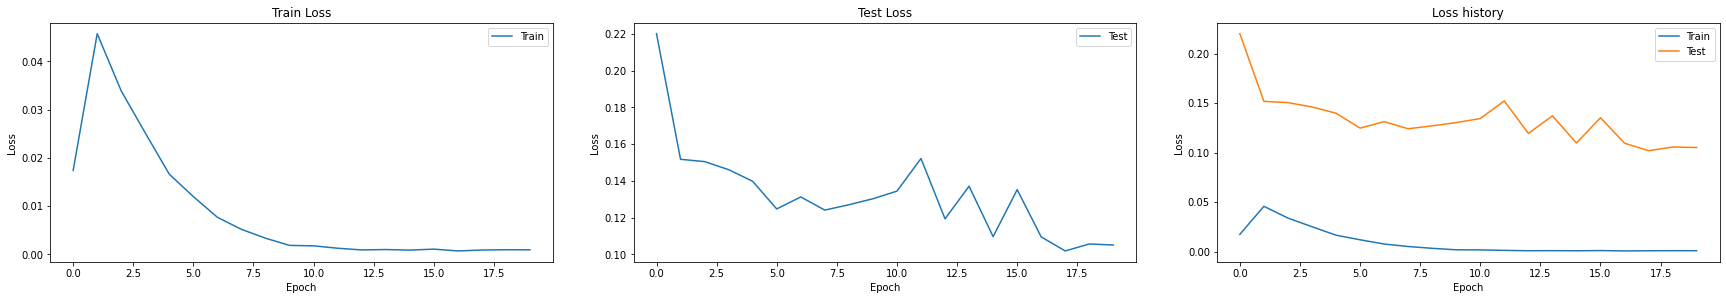

Finished training model

Finished evaluating model



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.0182504859
epoch:   2 loss: 0.0280764028
epoch:   3 loss: 0.0233245883
epoch:   4 loss: 0.0198198613
epoch:   5 loss: 0.0148908859
epoch:   6 loss: 0.0105028823
epoch:   7 loss: 0.0068660700
epoch:   8 loss: 0.0052514705
epoch:   9 loss: 0.0043704985
epoch:  10 loss: 0.0040029613
epoch:  11 loss: 0.0037398564
epoch:  12 loss: 0.0036067769
epoch:  13 loss: 0.0034819690
epoch:  14 loss: 0.0032157947
epoch:  15 loss: 0.0030196104
epoch:  16 loss: 0.0027523721
epoch:  17 loss: 0.0025414056
epoch:  18 loss: 0.0023724628
epoch:  19 loss: 0.0022092513
epoch:  20 loss: 0.0020191425


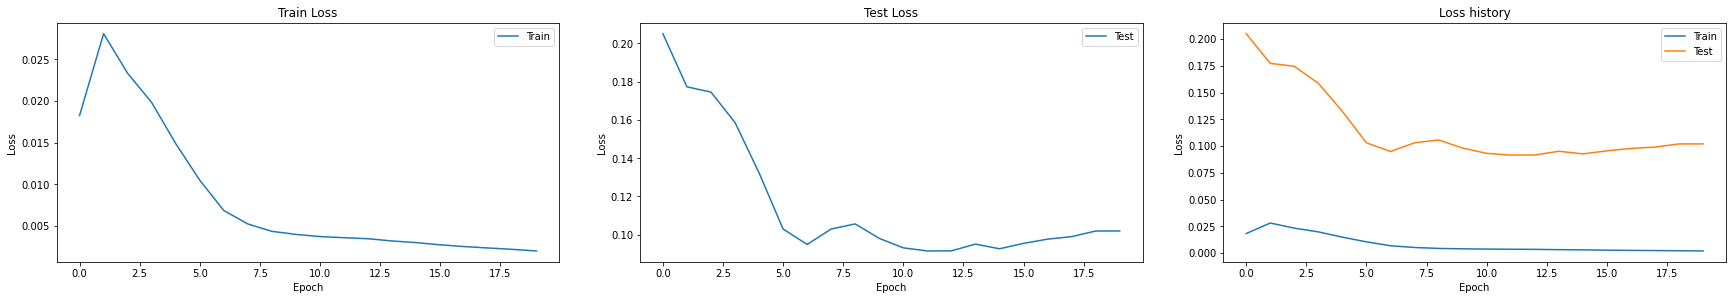

Finished training model

Finished evaluating model



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.0052717305
epoch:   2 loss: 0.0235792994
epoch:   3 loss: 0.0407783985
epoch:   4 loss: 0.0322087109
epoch:   5 loss: 0.0181731172
epoch:   6 loss: 0.0111150090
epoch:   7 loss: 0.0068244780
epoch:   8 loss: 0.0043079369
epoch:   9 loss: 0.0023604527
epoch:  10 loss: 0.0014113459
epoch:  11 loss: 0.0014782629
epoch:  12 loss: 0.0015101547
epoch:  13 loss: 0.0012471519
epoch:  14 loss: 0.0008462569
epoch:  15 loss: 0.0008278055
epoch:  16 loss: 0.0010403058
epoch:  17 loss: 0.0006717848
epoch:  18 loss: 0.0005441862
epoch:  19 loss: 0.0006816306
epoch:  20 loss: 0.0005744384


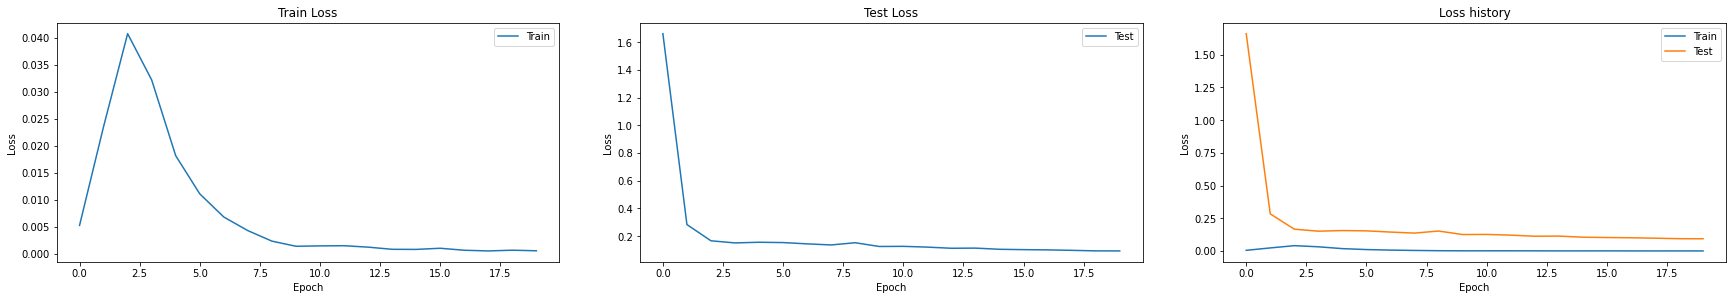

Finished training model

Finished evaluating model



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.0028016162
epoch:   2 loss: 0.0360065624
epoch:   3 loss: 0.0272493139
epoch:   4 loss: 0.0327163711
epoch:   5 loss: 0.0222663693
epoch:   6 loss: 0.0135214590
epoch:   7 loss: 0.0101598278
epoch:   8 loss: 0.0080125649
epoch:   9 loss: 0.0056820316
epoch:  10 loss: 0.0031216929
epoch:  11 loss: 0.0024975729
epoch:  12 loss: 0.0019677314
epoch:  13 loss: 0.0016080441
epoch:  14 loss: 0.0015284574
epoch:  15 loss: 0.0014791293
epoch:  16 loss: 0.0013236405
epoch:  17 loss: 0.0011403059
epoch:  18 loss: 0.0011831746
epoch:  19 loss: 0.0010404212
epoch:  20 loss: 0.0011020101


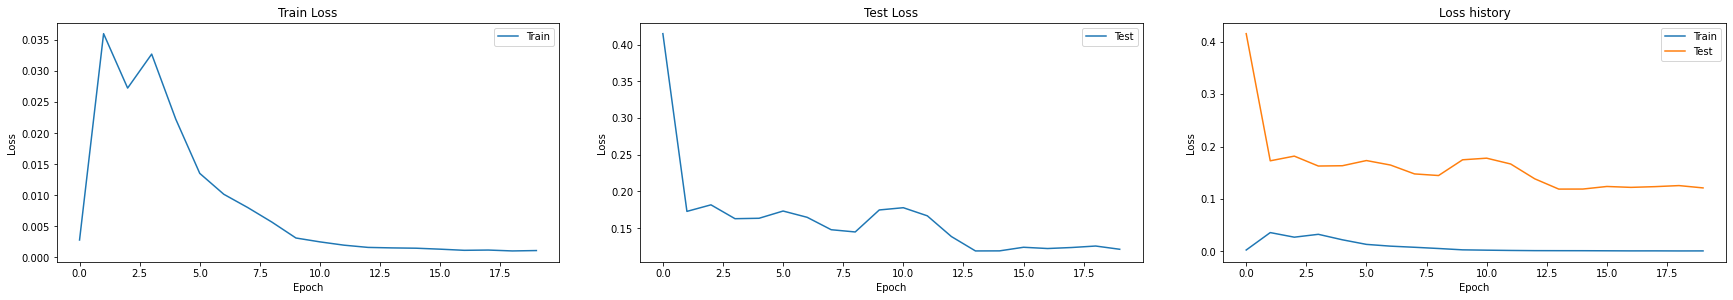

Finished training model

Finished evaluating model



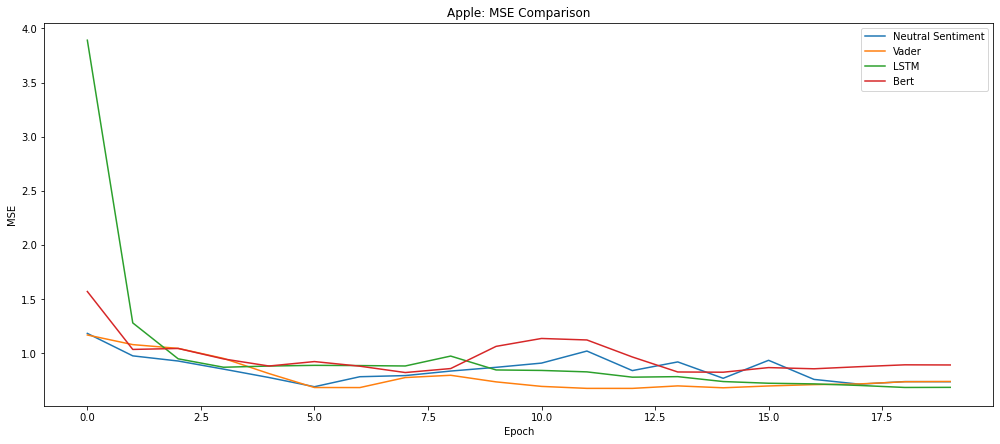

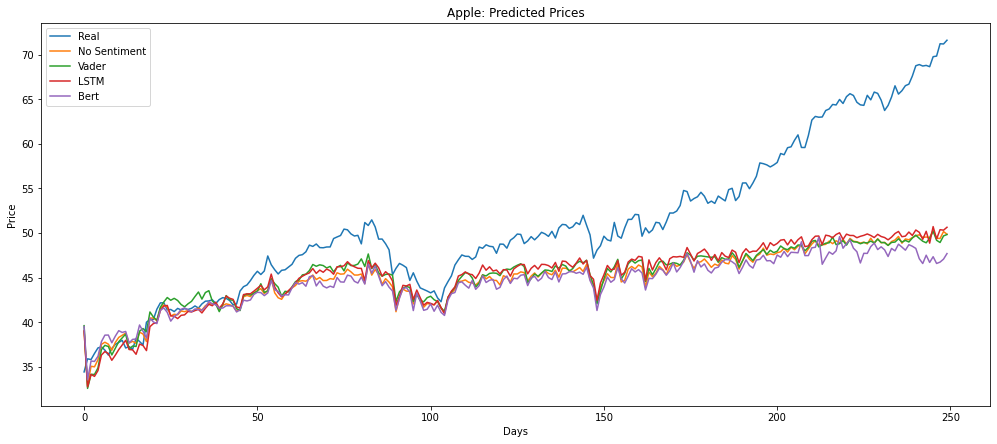

In [76]:
process_company('Apple', splitted_aapl_datasets, aapl_price_scaler, epochs, lr)
# process_company('Microsoft', splitted_msft_datasets, msft_price_scaler, epochs, lr)
# process_company('Amazon', splitted_amzn_datasets, amzn_price_scaler, epochs, lr)
# process_company('Tesla', splitted_tsla_datasets, tsla_price_scaler, epochs, lr)